In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as nnfunc
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import SGD
from torch.optim import lr_scheduler
from torch.utils.data import random_split, Subset
from skimage import filters
from torchvision.transforms import functional_tensor as F_t

In [3]:
class Segment(object):
    def __call__(self, img):
      image = img.numpy()
      val = filters.threshold_otsu(image)
      mask = image > val
      return torch.from_numpy(mask)

class Crop(object):
    def __call__(self, img):
      return F_t.crop(img, 0, 0, 115, 218)

In [4]:
classes = ['not_wearing','wearing_eyeglasses','wearing_hat']

transformer = transforms.Compose([
    transforms.ToTensor(),
    Crop(),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

train_path = 'data_wearing/train'
test_path = 'data_wearing/test'

train_data = torchvision.datasets.ImageFolder(train_path, transform=transformer)

train_ratio = 0.8
train_size = int(train_ratio * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

batch_size = 64
# set to true for GPU
pin_memory = False

train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    pin_memory = pin_memory
)

val_loader = DataLoader(
    val_set,
    batch_size = batch_size,
    shuffle = False,
    pin_memory = pin_memory
)

In [6]:
def ResBlock(in_channels, out_channels, pool=False):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    if pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = ResBlock(in_channels, 64)
        self.conv2 = ResBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ResBlock(128, 128), ResBlock(128, 128))
        self.conv3 = ResBlock(128, 256, pool=True)
        self.conv4 = ResBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ResBlock(512, 512), ResBlock(512, 512))
        self.fc = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.fc(out)
        return out

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = torchvision.models.resnet18(pretrained=False)
model = ResNet9(3,3)
# inchannel = model.fc.in_features
# model.fc = nn.Linear(inchannel, 3)

# Continue training
# best_model = torch.load('model/task2.model')
# model.load_state_dict(best_model, strict=False)

model.to(device)
torch.save(model.state_dict(), 'model/task2-resnet9-crop-adam-40.model')

lr = 0.01
weight_decay = 1e-4
num_epoches = 40
grad_clip = 0.1

train_count = len(train_set)
val_count = len(val_set)

optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.OneCycleLR(optimizer, lr, epochs=num_epoches, steps_per_epoch=train_count)

loss_function = nn.CrossEntropyLoss()

best_accuracy = 0.0

hist = []

for epoch in range(num_epoches):
    model.to(device)
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # gradient clipping
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data,1)
        train_accuracy += int(torch.sum(prediction == labels.data))
    
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss/train_count
    
    model.eval()
    val_accuracy = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)
            outputs = model(images)
            _,prediction = torch.max(outputs.data,1)
            val_accuracy += int(torch.sum(prediction==labels.data))

        val_accuracy = val_accuracy / val_count
        
        print(f"Epoch {epoch}")
        print(f"Train_accuracy {train_accuracy}")
        print(f"Train Loss {train_loss}")
        print(f"Val Accuracy {val_accuracy}")
        
        hist.append({ 
            'epoch':epoch,
            'train_accuracy':train_accuracy,
            'val_accuracy':val_accuracy,
            'best_accuracy':best_accuracy,
            'train_loss':train_loss
        })
        
        if val_accuracy > best_accuracy:
            print(f"Best Val Accuracy {val_accuracy}")
            torch.save(model.state_dict(), 'model/task2-resnet9-crop-adam-40.model')
            best_accuracy = val_accuracy

Epoch 0
Train_accuracy 0.7085326953748007
Train Loss 0.7984795570373535
Val Accuracy 0.759170653907496
Best Val Accuracy 0.759170653907496
Epoch 1
Train_accuracy 0.8221690590111643
Train Loss 0.44811388850212097
Val Accuracy 0.8708133971291866
Best Val Accuracy 0.8708133971291866
Epoch 2
Train_accuracy 0.8524720893141946
Train Loss 0.3695898652076721
Val Accuracy 0.8819776714513556
Best Val Accuracy 0.8819776714513556
Epoch 3
Train_accuracy 0.8875598086124402
Train Loss 0.2918931543827057
Val Accuracy 0.9011164274322169
Best Val Accuracy 0.9011164274322169
Epoch 4
Train_accuracy 0.9182615629984051
Train Loss 0.22123949229717255
Val Accuracy 0.886762360446571
Epoch 5
Train_accuracy 0.9154704944178629
Train Loss 0.21582715213298798
Val Accuracy 0.9122807017543859
Best Val Accuracy 0.9122807017543859
Epoch 6
Train_accuracy 0.937799043062201
Train Loss 0.16905739903450012
Val Accuracy 0.9298245614035088
Best Val Accuracy 0.9298245614035088
Epoch 7
Train_accuracy 0.94896331738437
Train Loss

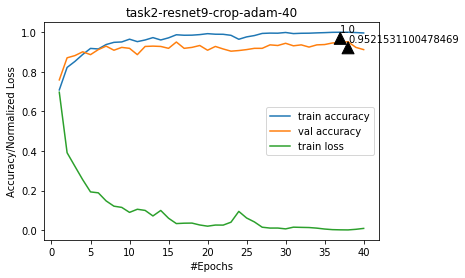

In [12]:
x = np.arange(1, len(hist)+1)

fig, ax = plt.subplots()  # Create a figure and an axes.
train_accuracy = list(map(lambda x: x['train_accuracy'], hist))
val_accuracy = list(map(lambda x: x['val_accuracy'], hist))

train_loss = list(map(lambda x: x['train_loss'], hist))
train_loss = train_loss / np.linalg.norm(train_loss)

plt.plot(x, train_accuracy, label='train accuracy')  # Plot some data on the axes.
plt.plot(x, val_accuracy, label='val accuracy')  # Plot more data on the axes...
plt.plot(x, train_loss, label='train loss')  # ... and some more.
plt.xlabel('#Epochs')  # Add an x-label to the axes.
plt.ylabel('Accuracy/Normalized Loss')  # Add a y-label to the axes.
plt.title("task2-resnet9-crop-adam-40")  # Add a title to the axes.
plt.legend()  # Add a legend.

plt.annotate(f'{np.max(train_accuracy)}', xy=(np.argmax(train_accuracy) + 1, np.max(train_accuracy)), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'{np.max(val_accuracy)}', xy=(np.argmax(val_accuracy) + 1, np.max(val_accuracy)), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()